# Clustering & Geodemographics

A common challenge in data analysis is how to group observations in a data set together in a way that allows for generalisation: _this_ group of observations are similar to one another, _that_ group is dissimilar to this group. But what defines similarity and difference? There is no _one_ answer to that question and so there are many different ways to cluster data, each of which has strengths and weaknesses that make them more, or less, appropriate in different contexts.

## Clustering in Python

The most commonly-used _aspatial_ clustering algorighms are all found in [scikit-learn](http://scikit-learn.org/stable/), so that will be the focus of this practical. But just as there are aspatial and spatial statistics, there are also _spatially-aware_ clustering algorithms to be found in [PySAL](http://pysal.readthedocs.io/en/latest/), the Python Spatial Analysis Library.

### Clustering in sklearn

One organisation recently produced a handy scikit-learn cheatsheet that you should [download](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf). The terminology used in scikit-learn is rather different from anything you will have encountered before (unless you've studied computer science and, possibly, statistics) so it's worth spending a few minutes mapping what you already know on to the sklearn framework:

  | Continuous | Categorical
- | ---------- | -----------
**Supervised** | Regression | Classification
**Unsupervised** | Dimensionality Reduction | Clustering

So clustering is a form of unsupervised (because we don't train the model on what a 'good' result looks like) and categorical (because we get labels out of the model, not predictors) machine learning. Clustering is often used together with PCI (Principal Components Analysis) which is a form of unsupervised dimensionality reduction: data sets with "high dimensionality" are reduced using PCI (you can think of this as a realignment of the axes with the 'data cloud') which has the effect of _maximising the variance_ on each new axis, and the reduced-dimension dataset is then fed to a clustering algorithm. Similarly, supervised approaches are often paired: logistic regression (supervised) is often used with classification (supervised).

Anyway, here's a map to sklearn's algorithms and how to navigate them:

<a href="http://scikit-learn.org/stable/tutorial/machine_learning_map/"><img alt="SciKit-Learn Algorithm Map" src="http://scikit-learn.org/stable/_static/ml_map.png"></a>

### Clustering in PySAL

PySAL is similarly complex and _also_ has a map to help you navigate its complexities -- in this case we're particularly interested in the orange 'branch' of PySAL (labelled clustering!):

![PySAL Map](http://darribas.org/gds_scipy16/content/figs/pysal.png)

### Which Approach is Right?

The reason that there is no 'right' approach (as I said above) is that it all depends on what you're trying to accomplish and how you're _reasoning_ about your problem. The image below highlights the extent to which the different clustering approaches in sklearn can produce different results -- and this is only for the _non-geographic_ algorithms!

<a href="http://scikit-learn.org/stable/modules/clustering.html#clustering"><img alt="Clustering algorithm comparison" src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png" /></a>

To think about this in a little more detail:

* If I run an online company and I want to classify my customers on the basis of their product purchases, then I probably don't care much about where they are, only about what they buy. So my clustering approach doesn't need to take geography into account. I might well _discover_ that many of my most valuable customers live in a few areas, but that is a finding, not a factor, in my research.
* Conversely, if I am looking for cancer clusters then I might well care a _lot_ about geography because I want to make sure that I don't overlook a bigger cluster because it's 'hidden' inside an area with lots of non-sufferers. In that case, I want my clusters to take geography into account because I'm looking for agglomerations. That approach might classify an area with a smaller proportion of cancer patients as part of a 'cancer cluster' but that's because it is still significant _because_ of the geography.

So you can undertake a spatial analysis using _either_ approach, it just depends on the role that you think geography should play in producing the clusters in the first place. We'll see this in action today!

## Obtaining Geodemographic Data

For the sake of simplicity we're going to work with roughly the same set of data for London that Alexiou & Singleton used in their _Geodemographic Analysis_ chapter from [Geocomputation: A Practical Primer](https://uk.sagepub.com/en-gb/eur/geocomputation/book241023). Although the implementation in the _Primer_ is in the R programming language, the concerns and the approach are exactly the same.

### NomisWeb

In case you've forgotten, nearly the _entire_ Census is available to download from [InFuse](http://infuse2011.ukdataservice.ac.uk/), but you can often download data 'in bulk' from [NomisWeb](https://www.nomisweb.co.uk/home/detailedstats.asp?resume=no) directly. 

#### Demographic Data

The tables we want are:
* KS102EW: Age structure
* KS201EW: Ethnic group
* KS401EW: Dwellings, household space and accommodation type
* KS402EW: Tenure
* KS403EW: Rooms, bedrooms and central heating
* KS404EW: Car or van availability
* KS501EW: Qualifications and students
* KS603EW: Economic Activity by Sex

To save you the trouble of manually selecting and downloading each table I have assembled everything into a 'Census.zip' file.

#### Geographic Areas

We want London LSOAs, which you can get by specifying 'Select areas within', then '2011 - super output areas - lower layers', and 'region' (leading to London). 

### ONS Boundary Data

Now we need to download the LSOA boundary data. A quick Google search on "2011 LSOA boundaries" will lead you to the [Data.gov.uk portal](https://data.gov.uk/dataset/lower_layer_super_output_area_lsoa_boundaries). The rest is fairly straightforward:
* We want 'generalised' because that means that they've removed some of the detail from the boundaries so the file will load (and render) more quickly.
* We want 'clipped' because that means that the boundaries have been clipped to the edges of the land (e.g. the Thames; the 'Full' data set splits the Thames down the middle between adjacent LSOAs).

**_Note:_** be sure that you select the **2011** data, not the **2001** data.

### Setup

You should drag both the LSOA boundary file and the Census zipfile into a 'data' directory that is the same directory as this notebook so that they're easy to access. You should then:
* Unzip _only_ the LSOA zipfile.
* Rename the directory containing LSOA data to 'lsoa'.

And we're ready to go!

### Other Sources of Data

If you're more interested in US Census data then there's a nice-looking (I haven't used it) [wrapper to the Census API](https://pypi.python.org/pypi/census).

## Getting to Work

To get started we're going to work with pandas and geopandas -- again, nothing new so far but you'll see we've got some new libraries here.

### Specifying the Kernel

**_Note:_** Before you go any further, we need to check that you've got the right 'Kernel' (virutal environment) specified in Jupyter. At top right it should say "Python [spats]" and that is the environment that we want to work in: spats is short Spatial Analysis and that contains all of the libraries that we need for our research. There are other kernels configured and these can be accessed by clicking on the 'Kernel' menu item and then 'Change Kernel'. This feature is well beyond the scope of this practical, but it basically allows you to run multiple 'versions' of Python with different libraries or versions of libraries installed at the same time.

### Importing the Libraries

In [1]:
import pysal as ps
import pandas as pd
import geopandas as gpd
import seaborn as sns
import clusterpy as cpy
import os
import re
import numpy as np
import zipfile

import random
random.seed(123456789) # For reproducibility

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))

# Make sure output is into notebook
%matplotlib inline

ClusterPy: Library of spatially constrained clustering algorithms


### Loading the Geodata

Unlike the NS-SeC data this is fairly straightforward using geopandas:

In [2]:
gdf = gpd.read_file(os.path.join('data','lsoa','Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp'))
print("Shape of LSOA file: {0} rows by {1} columns".format(gdf.shape[0], gdf.shape[1]))
gdf.head(2)

Shape of LSOA file: 34753 rows by 7 columns


,geometry,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths
0,"POLYGON ((532106.8939689073 182011.4758723566,...",E01000001,City of London 001A,City of London 001A,1,"133,321","2,292"
1,"POLYGON ((532748.6236845022 181787.1247154782,...",E01000002,City of London 001B,City of London 001B,2,"226,191","2,434"


### Loading the Census Data

You may need to make a few adjustments to the path to get the data loaded on your own computer. But notice what we're now able to do here: using the `zipfile` library we can extract a data file (or any other file) from the Zip archive without even having to open it. Saves even more time _and_ disk space!

In [8]:
z = zipfile.ZipFile(os.path.join('data','Census.zip'))
z.namelist()

['148410511-Dwellings.csv',
 '2596417429-Age.csv',
 '2653932334-Ethnicity.csv',
 '2735213988-Tenure.csv',
 '2790216173-Vehicles.csv',
 '2874717391-Tenure.csv',
 '3248615150-Qualifications.csv',
 '99521530-Activity.csv']

In [45]:
print("Processing: " + z.namelist()[0])
df = pd.read_csv(z.open(z.namelist()[0]), header=6, skip_blank_lines=True, skipfooter=7, engine='python')

Processing: 148410511-Dwellings.csv


In [43]:
df.head(3)

,2011 super output area - lower layer,mnemonic,Unshared dwelling,Shared dwelling: Two household spaces,Shared dwelling: Three or more household spaces,Household spaces with at least one usual resident,Household spaces with no usual residents,Whole house or bungalow: Detached,Whole house or bungalow: Semi-detached,Whole house or bungalow: Terraced (including end-terrace),"Flat, maisonette or apartment: Purpose-built block of flats or tenement","Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)","Flat, maisonette or apartment: In a commercial building",Caravan or other mobile or temporary structure
0,Camden 001A,E01000907,628,1,0,627,3,14,26,97,387,106,0,0
1,Camden 001B,E01000908,836,1,3,827,42,15,82,33,636,98,5,0
2,Camden 001C,E01000909,674,0,1,661,16,79,143,64,239,143,9,0


In [46]:
for r in range(1, len(z.namelist())):
    print("Processing file: " + z.namelist()[r])
    df1 = pd.read_csv(z.open(z.namelist()[r]), header=6, skip_blank_lines=True, skipfooter=7, engine='python')
    print("\tShape of dataframe is {0} rows by {1} columns".format(df1.shape[0], df1.shape[1]))
    if np.where(df1.columns.values=='mnemonic')[0]:
        df = df.merge(df1, how='inner', left_on='mnemonic', right_on='mnemonic')
    else:
        print("Couldn't find matching column in: " + z.namelist()[r])

print(df.columns)

Processing file: 2596417429-Age.csv
	Shape of dataframe is 4835 rows by 19 columns
Processing file: 2653932334-Ethnicity.csv
	Shape of dataframe is 4835 rows by 8 columns
Processing file: 2735213988-Tenure.csv
	Shape of dataframe is 4835 rows by 10 columns
Processing file: 2790216173-Vehicles.csv
	Shape of dataframe is 4835 rows by 8 columns
Processing file: 2874717391-Tenure.csv
	Shape of dataframe is 4835 rows by 8 columns
Processing file: 3248615150-Qualifications.csv
	Shape of dataframe is 4835 rows by 10 columns
Processing file: 99521530-Activity.csv
	Shape of dataframe is 4836 rows by 2 columns
Couldn't find matching column in: 99521530-Activity.csv
Index([u'2011 super output area - lower layer_x', u'mnemonic',
       u'Unshared dwelling', u'Shared dwelling: Two household spaces',
       u'Shared dwelling: Three or more household spaces',
       u'Household spaces with at least one usual resident',
       u'Household spaces with no usual residents',
       u'Whole house or bungal

#### Tidying Up

OK, that's not the most 'useful' of column headings: quite a lot of typing and redundancy to say the least! But we can use code to clean this up!

Let's step through it:
* We first test for the existence of a column at the far end of the file -- since `pandas` stores its columns as an index, we need to extract the values from the index (which returns a `numpy` array) and then look through it for something match `Unnamed: 26`.
* Next, we create a new list called `colnames` and we initialise it with the names we want to use for columns `Unnamed: 0` through `Unnamed: 4`.
* Then we're going to iterate over the remaining column names to try to turn them into something more useful. Note that we use `len(colnames)` to `len(df.columns)` in the `range` function so that if we add or remove lists items from the line above, or if we decide to download a different data set with a different number of columns, then this code continues to work!
* When all of that is done, we assign the new column labels on to the dataframe. 

Done!

In [26]:
# If we find this column, this deletes it
if np.where(df.columns.values=='Unnamed: 26')[0]:
    del df['Unnamed: 26']

# Initialise the new columns names list
colnames = ['CDU','GeoCode','GeoLabel','GeoType','GeoType2']
col_desc = {'GeoCode': 'GeoID', 'GeoLabel': 'GeoName'}

# Now tidy up the remaining columns
for i in range(len(colnames), len(df.columns)):
    #print(df.columns[i])
    
    # Strip out useless verbiage
    label = df.columns[i].replace('Age : Age 16 to 74 - NS-SeC (National Statistics Socio-economic Classification) : ','')
    label = label.replace(' - Unit : Persons','')
    #print(label)
    
    # Check for a pattern at the start of the label
    m = re.search("^(L?\d(\.?\d?)?).?\s", label)
    if m is not None:
        #print("'" + m.group(1) + "'")
        group_id = m.group(1)
        group_id = 'Group' + group_id.replace('.','',1)
        col_desc[group_id] = label
        colnames.append(group_id)
        # Debugging
        # print("Mapped '{0}' to '{1}'").format(label, group_id)
    elif label.startswith("Total"):
        col_desc['Total'] = label
        colnames.append('Total')
    elif label.startswith("Not classified"):
        m = re.search("\s(L\d+)\s", label)
        if m is not None:
            group_id = m.group(1)
            group_id = 'Group' + group_id.replace('.','',1)
            col_desc[group_id] = label
            colnames.append(group_id)
            # Debugging
            #print("Mapped '{0}' to '{1}'").format(label, group_id)
        else: 
            col_desc['GroupNC'] = label
            colnames.append('GroupNC')
    else:
        print("Don't know what to do with: " + label)

# Final check
print(colnames)

['CDU', 'GeoCode', 'GeoLabel', 'GeoType', 'GeoType2', 'Total', 'Group1', 'Group11', 'Group12', 'Group2', 'Group3', 'Group4', 'Group5', 'Group6', 'Group7', 'Group8', 'GroupNC', 'GroupL15', 'GroupL17', 'GroupL4', 'GroupL5', 'GroupL6', 'GroupL8', 'GroupL9', 'GroupL10', 'GroupL11']


In [27]:
df.columns = colnames

# These are pointless but were hard to 
# get at before because of the column names!
if np.where(df.columns.values=='GeoType')[0]:
    del df['GeoType']
if np.where(df.columns.values=='GeoType2')[0]:
    del df['GeoType2']

df.head(2)

,CDU,GeoCode,GeoLabel,Total,Group1,Group11,Group12,Group2,Group3,Group4,...,GroupNC,GroupL15,GroupL17,GroupL4,GroupL5,GroupL6,GroupL8,GroupL9,GroupL10,GroupL11
0,19263,E01000001,City of London 001A,1221,530,69,461,429,73,68,...,55,55,0,300,103,26,18,50,8,4
1,19264,E01000002,City of London 001B,1196,518,88,430,392,83,85,...,60,60,0,274,88,30,25,60,11,4


## Standardising the Data

The effectiveness of clustering algorithms is usually demonstrated using the 'iris data' -- it's available by default with both Seaborn and SciKit-Learn. This data doesn't usually need normalisation but it's a good way to start looking at the data across four dimensions and seeing how it varies and why some dimensions are 'good' for clustering, while others are 'not useful'...

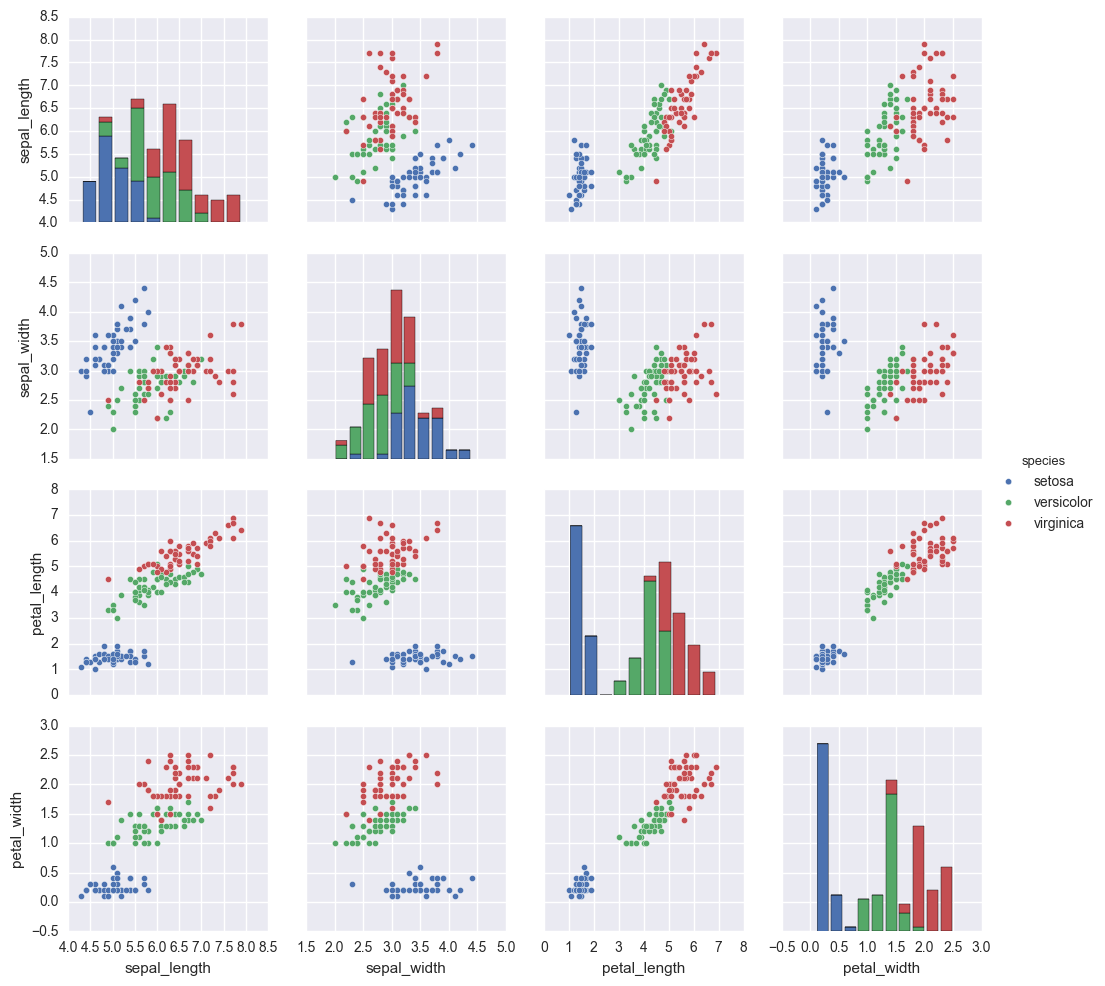

In [6]:
sns.set()
irises = sns.load_dataset("iris")
sns.pairplot(irises, hue="species")

### Why Standardise

One of the main challenges of clustering, however, is that the scale of each dimension matters: if you were to try to cluster, for example, [1] how many metres per year a glacier moved with [2] the number of cubic metres by which it grew, then you would only be clustering on variable [2]. 

That's because glaciers contain millions of cubic metres of ice and will grow or shrink by thousands of cubic metres each year. In contrast, most glaciers move at most a few metres per year. So the sheer scale difference between these two dimensions means that the values of variable 1 dominate the clustering algorithm because they provide a much better 'spread' in the data than variable 2.

To address this we need to standardise the data in some way so that the scales are relatively consistent. There's no _one_ way to standardise the data, it depends on the characteristics of the data _as well as_ what we're looking for in terms of clustering. As a general rule, we're _aiming_ for a normal (a.k.a. Gaussian) distribution with 0 mean and unit variance. The latter part of this is what most people focus on: you may recall our work with transformations last year, and here's one more reason why it's useful. That said, normalisation (making the data 'look' normal) can also be very important for the process since it can significantly skew the results as well if the data itself is heavily skewed.

Right, so does this all sound a little bit familiar from last year? Let's start by just looking at a couple of variables in a simple scatter plot...

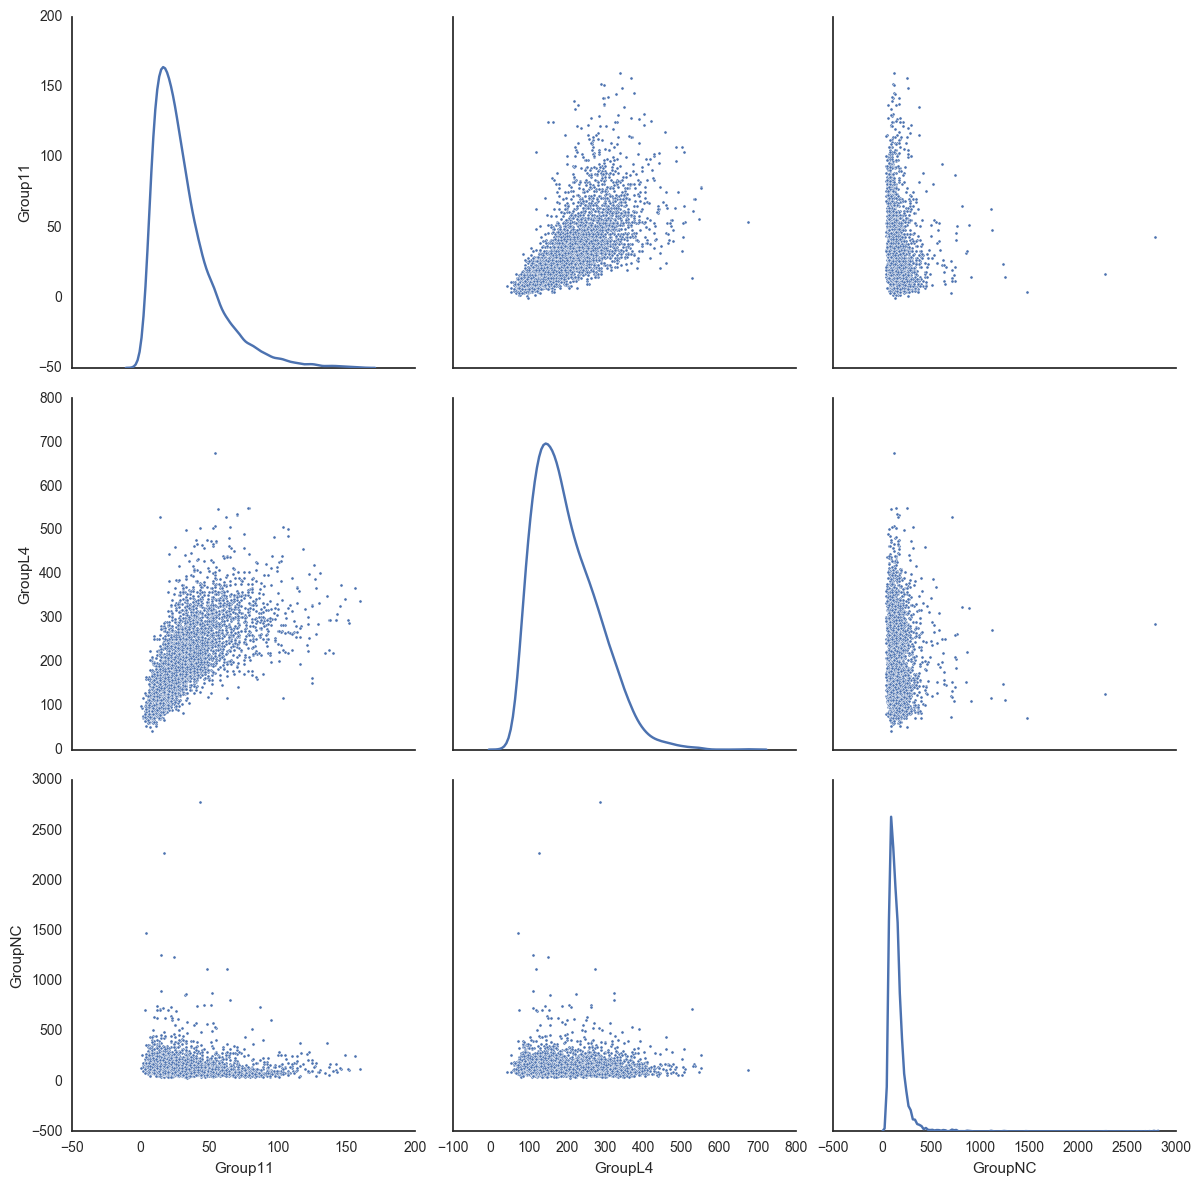

In [30]:
# The data as it is now...
sns.set(style="white")
sns.pairplot(df, 
             vars=['Group11','GroupL4','GroupNC'], 
             markers=".", size=4, diag_kind='kde')

So there are clearly some differences, but I'd be hard-pressed to give you sensible clusters just by looking at this data. In particular, we have a _real_ problem with the comparisons since GroupL15 _looks_ like it has a very compressed distribution... until you see that its scale is 0--3,000, whereas the others are 0--200 or 0--700! If we have this problem of comparing different scales, so does the computer.

### Standardisation with SKLearn

Let's try standardising the data now:

In [31]:
# Here's how we can rescale in a robust way
import sklearn
print("SciKit-Learn verion is: " + sklearn.__version__)
from sklearn import preprocessing
help(preprocessing.robust_scale)

SciKit-Learn verion is: 0.18.1
Help on function robust_scale in module sklearn.preprocessing.data:

robust_scale(X, axis=0, with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)
    Standardize a dataset along any axis
    
    Center to the median and component wise scale
    according to the interquartile range.
    
    Read more in the :ref:`User Guide <preprocessing_scaler>`.
    
    Parameters
    ----------
    X : array-like
        The data to center and scale.
    
    axis : int (0 by default)
        axis used to compute the medians and IQR along. If 0,
        independently scale each feature, otherwise (if 1) scale
        each sample.
    
    with_centering : boolean, True by default
        If True, center the data before scaling.
    
    with_scaling : boolean, True by default
        If True, scale the data to unit variance (or equivalently,
        unit standard deviation).
    
    quantile_range : tuple (q_min, q_max), 0.0 < q_min < q_m

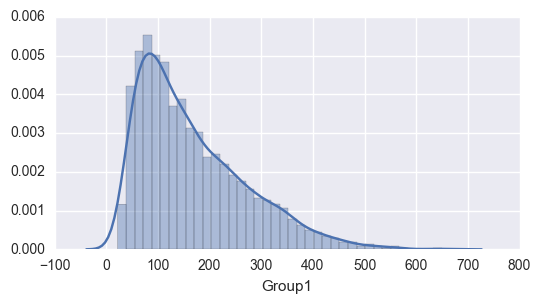

In [32]:
# Before rescaling
sns.set(rc={"figure.figsize": (6,3)})
sns.distplot(df.Group1)

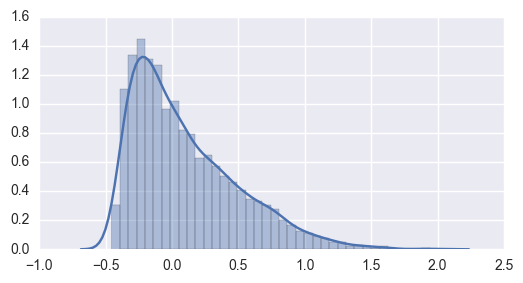

In [33]:
# After rescaling -- notice the difference?
sns.distplot(
    preprocessing.robust_scale(df.Group1.values.reshape(-1, 1), 
                               quantile_range=(10.0, 90.0)))

OK, so we've got rescaling working, but before we blindly apply this to every column in the data set let's think about what we're really up to. If we proceed with the clustering on this basis then we are clustering on _raw_ population alone. So we'll tend to find small areas being grouped together with other small areas. That's not really what we're looking for: we want areas with similar overall _profiles_ of users to come out in the same cluster.

We _could_ convert everything to percentages and that would be a reasonable form of standardisation, but I prefer the LQ because it gives us a better range to work with, and areas that have a relatively higher concentration of two groups will come out looking similar even if they are of very different sizes!

In [34]:
# Make numeric display a bit easier for LQs
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))

# Convert all of the NS-SeC Groups to LQs
for group in df.columns:
    if group.startswith('Group'):
        df[group+'LQ'] = pd.Series( (df[group]/df['Total']) / (float(df[group].sum()) / df.Total.sum()))

df.sample(3)[['GeoCode','Total','Group1','Group4','GroupNC','Group1LQ','Group4LQ','GroupNCLQ']]

,GeoCode,Total,Group1,Group4,GroupNC,Group1LQ,Group4LQ,GroupNCLQ
2221,E01002272,995,103,131,65,0.784,1.400,0.571
1815,E01001862,1434,201,114,116,1.061,0.845,0.707
1246,E01001266,1404,115,192,173,0.620,1.454,1.076


If we look at the plot of three LQs below, again, this hasn't radically changed the shape of our data but it has already converted the data to a range that is more tractable for our purposes. So the LQ is performing a kind of standardisation that's quite handy and it has also had the benefit of making unity (or '1' in plain English) a meaningful value (it means "about what we expected", if you remember Geocomputation from last year).

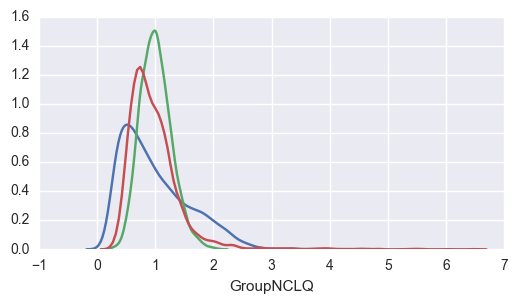

In [35]:
sns.distplot(df.Group1LQ, hist=False)
sns.distplot(df.Group4LQ, hist=False)
sns.distplot(df.GroupNCLQ, hist=False)

There is, however, one thing I'd like to look out for: in dividing through for the LQ, if we had a denominator of zero at any point then we will have ended up with a `NaN` (Not a Number) or a `inf` (Infinity). 

It's worthwhile to have a quick sanity-check of the results:

In [38]:
df.isnull().any()

CDU           False
GeoCode       False
GeoLabel      False
Total         False
Group1        False
Group11       False
Group12       False
Group2        False
Group3        False
Group4        False
Group5        False
Group6        False
Group7        False
Group8        False
GroupNC       False
GroupL15      False
GroupL17      False
GroupL4       False
GroupL5       False
GroupL6       False
GroupL8       False
GroupL9       False
GroupL10      False
GroupL11      False
Group1LQ      False
Group11LQ     False
Group12LQ     False
Group2LQ      False
Group3LQ      False
Group4LQ      False
Group5LQ      False
Group6LQ      False
Group7LQ      False
Group8LQ      False
GroupNCLQ     False
GroupL15LQ    False
GroupL17LQ     True
GroupL4LQ     False
GroupL5LQ     False
GroupL6LQ     False
GroupL8LQ     False
GroupL9LQ     False
GroupL10LQ    False
GroupL11LQ    False
dtype: bool

OK, so it's only `GroupL17LQ` that's the issue here and not some systematic problem. At this point it is kind of up to us what we want to do: we could investigate further (digging into group L17 and possibly cleaning it up further... including through a simple transformation such as adding `1` to every value so that there are no zero values in the data), but since there is only this one variable and it's not integral to our analysis I'm in favour for dropping it. 

We could also explore whether `<data series>.fillna` could help us out, but I still lean towards just dropping the column because it's unlikely to be very useful to us.

In [39]:
dflq = df.copy(deep=True)

# If we find this column, this deletes it
if np.where(dflq.columns.values=='GroupL17LQ')[0]:
    del dflq['GroupL17LQ']

# And let's get rid of the non-LQ columns as well
# just to tidy up a little bit
drop = [ i for i, group in enumerate(dflq.columns) if group.startswith('Group') and not group.endswith('LQ') ]
dflq = dflq.drop(dflq.columns[drop], axis=1)

dflq.sample(3).head()

,CDU,GeoCode,GeoLabel,Total,Group1LQ,Group11LQ,Group12LQ,Group2LQ,Group3LQ,Group4LQ,...,Group8LQ,GroupNCLQ,GroupL15LQ,GroupL4LQ,GroupL5LQ,GroupL6LQ,GroupL8LQ,GroupL9LQ,GroupL10LQ,GroupL11LQ
34,19297,E01000037,Barking and Dagenham 003B,1329,0.427,0.390,0.436,0.858,1.546,1.072,...,0.955,0.730,0.730,0.757,0.985,1.272,0.962,1.106,1.231,2.674
454,19717,E01000460,Bexley 022E,1075,1.120,1.445,1.044,1.214,1.707,1.167,...,0.236,0.910,0.910,1.120,1.454,1.324,1.486,1.070,0.548,1.150
4698,51219,E01032782,Tower Hamlets 033D,1265,1.622,1.511,1.648,1.090,0.715,0.437,...,1.261,1.457,1.457,1.143,1.251,0.352,0.577,0.394,0.646,0.407


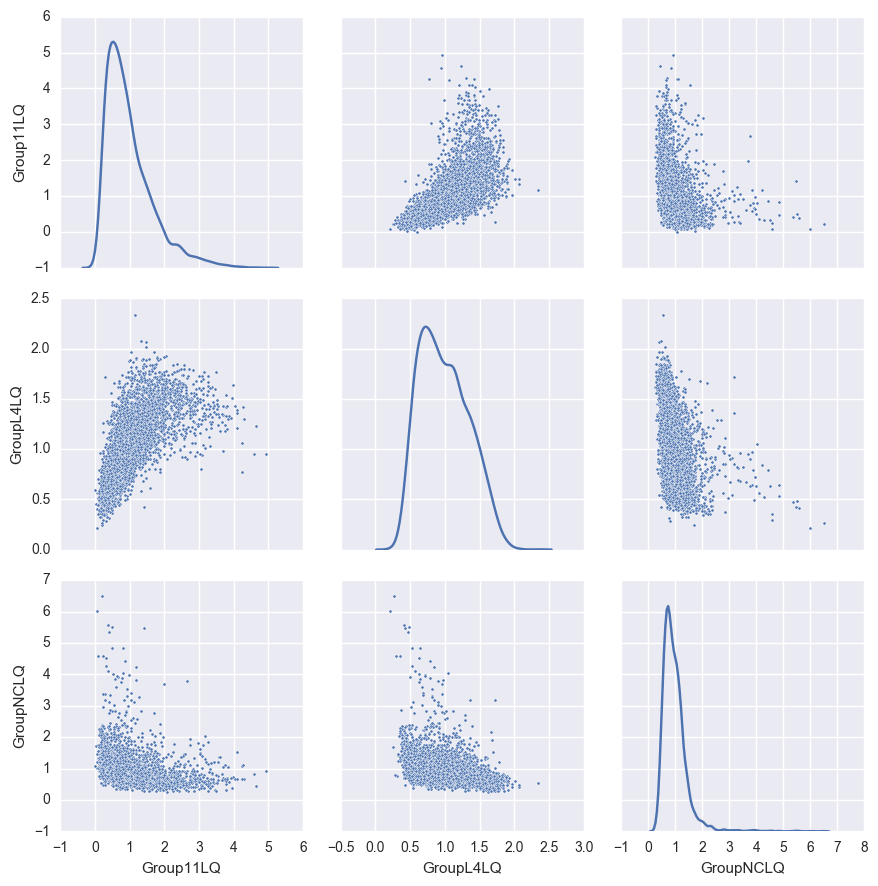

In [40]:
sns.pairplot(dflq, 
             vars=['Group11LQ','GroupL4LQ','GroupNCLQ'], 
             markers=".", size=3, diag_kind='kde')

Right, so that hasn't fundamentally changed the data, but it has rescaled it so that the the data it broadly re-centered on 1 and yet we still have the original outliers from the raw data. So this _should_ give us a bit more subtlety that brute-force max/min rescaling because it allows outliers to remain outliers without over-compressing the data. 

You could _also_ do inter-decile (0.1 to 0.9) or IQR standardisation (0.25 and 0.75) with the percentages, but in those cases you would have _more_ outliers and then _more_ extreme values skewing the results of the clustering algorithm.

### A Final Standardisation Step?

A last consideration is whether or not we should now fully rescale the data so it all falls into the 0-to-1 range: the standardisation process has given us a better perspective on _where_ high concentrations of different groups might be found, but we still need to decide whether the clustering or other machine learning processes should be influenced by the full range of the data. I lean towards _not_ rescaling on the basis that super-high concentrations of particular groups _should_ have a significant impact on the results of the clustering process, but it does mean that we're more likely to get one large cluster (containing the bulk of the non-extreme data) and a number of small clusters (each containing a small number of 'extreme' LSOAs). 

My point is that it's debatable -- the right choice is the one that you can argue for. There are plenty of researchers who would disagree with me on the paragraph above.

## Normalisation

As you'll have read in the _Gecomputation_ chapter, it's common to normalise the data after standardisation. This raises similar questions to the ones discussed immediately above: do we want more balanced clusters or not? I've not given you code to normalise the data, but you might like to compare the results with and without normalisation after seeing how you can adapt the code block below to work with all of the columns in the data frame.

### Box-Cox Transformations

SciPy gives you the ability to run Box-Cox transformations which try to find the most normal-like distribution that can be produced from your data. Unlike the 'standard' transformations (square-root, cube-root, square, natural log, etc.), Box-Cox works out an arbitrary exponent to use for the transformation iteratively (i.e. computationally). So instead of $x^{1/2}$ we might end up with $x^{0.274537}$. 

This is kind of a heady 'power' (pardon the pun) so it should be used with care, but it is extremely useful for working with non-normal data where it significantly affects your results.

Why don't you try the clustering process both ways? You might find that some algorithms perform well on the standardised but un-normalised data, while others are the reverse.

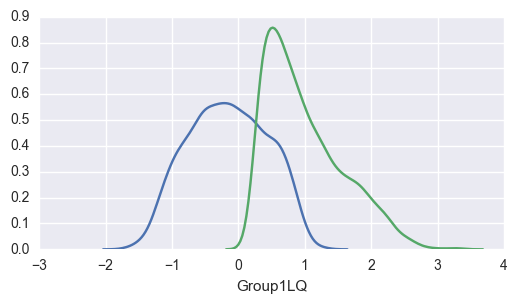

In [49]:
from scipy.stats import boxcox
x, _ = boxcox(dflq.Group1LQ)
x
sns.distplot(x, hist=False)
sns.distplot(dflq.Group1LQ, hist=False)

## Let's Cluster!

### Organising the Data


### K-Means

In [50]:
from sklearn.cluster import KMeans
help(KMeans)

Help on class KMeans in module sklearn.cluster.k_means_:

class KMeans(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin)
 |  K-Means clustering
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, optional, default: 8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  max_iter : int, default: 300
 |      Maximum number of iterations of the k-means algorithm for a
 |      single run.
 |  
 |  n_init : int, default: 10
 |      Number of time the k-means algorithm will be run with different
 |      centroid seeds. The final results will be the best output of
 |      n_init consecutive runs in terms of inertia.
 |  
 |  init : {'k-means++', 'random' or an ndarray}
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up co

The next code block may take a while to complete, largely because of the `pairplot` at the end where we ask Seaborn to plot every dimension against every other dimension _while_ colouring the points according to their cluster. I've reduced the plotting to just three dimensions, if you want to plot all of them, then just replace the array attached to `vars` with `main_cols`, but you have to bear in mind that that is plotting 4,300 points _each_ time it draws a plot... and there are 81 of them! It'll take a while, but it _will_ do it, and try doing that in Excel or SPSS?

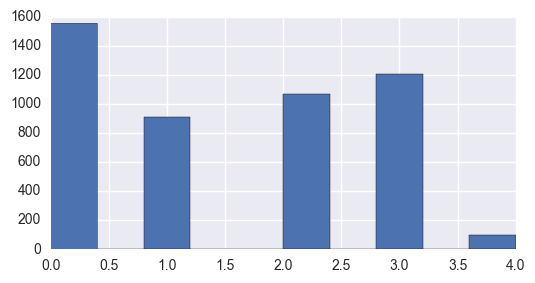

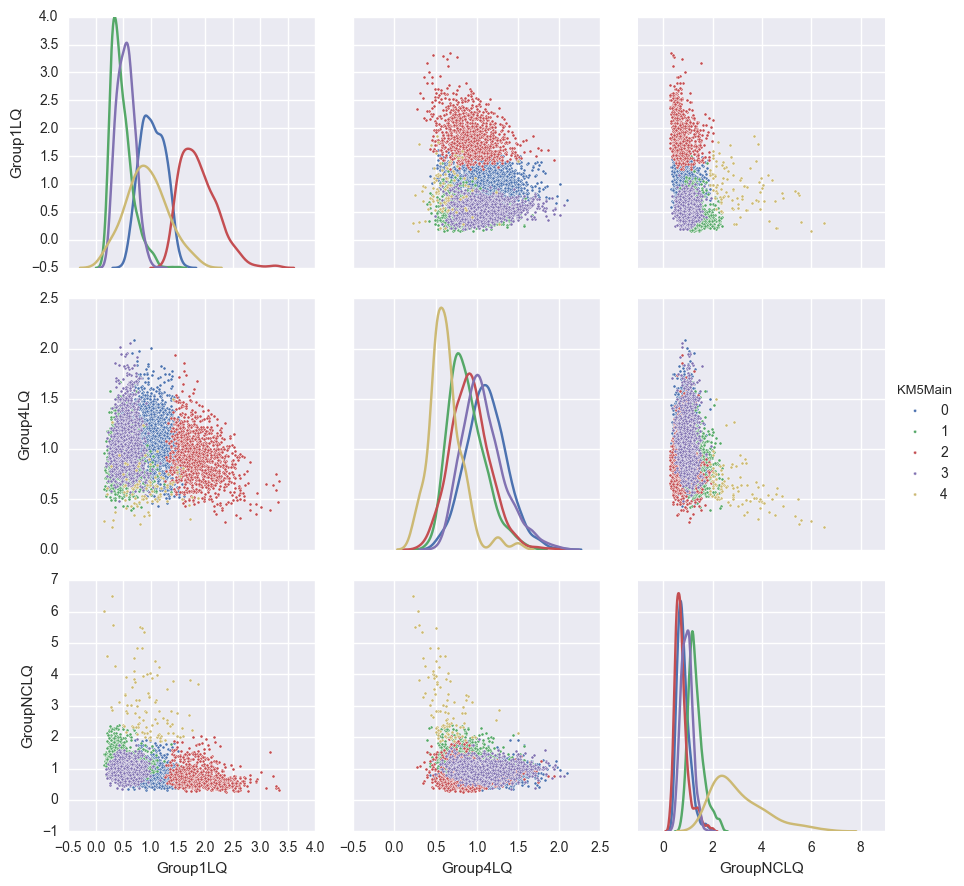

In [51]:
main_cols = ['Group1LQ','Group2LQ','Group3LQ','Group4LQ','Group5LQ','Group6LQ','Group7LQ','Group8LQ','GroupNCLQ']
kmeans = KMeans(n_clusters=5).fit(dflq[main_cols])
dflq['KM5Main'] = pd.Series(kmeans.labels_)
dflq.KM5Main.hist() # How are the clusters distributed?
# Going to be a bit hard to read
sns.pairplot(dflq,  
             vars=['Group1LQ','Group4LQ','GroupNCLQ'], 
             hue='KM5Main', markers=".", size=3, diag_kind='kde')

You can see that the outliers on the Group 1 and Not Classified LQ dimensions have been grouped into clusters. The other clusters have tended to cut through the bulk of the data, but if you look at the above map then you'll see that it has done a decent job of splitting the data sets into groups given that most of the data _isn't_ extreme.

### One More Thing...

There's just _one_ little problem: what assumption did I make when I started this _k_-means cluster analysis? It's a huge one, and it's one of the reasons that _k_-means clustering _can_ be problematic when used naively...

How did I pick the number of clusters?

### The Silhouette Plot

To try to make the process of selecting the number of clusters a little less arbitrary, the silhouette plot allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. So to evaluate this in a systematic way, we want to do _multiple_ _k_-means passes at _multiple_ values of _k_ and then we can look at which gives the best results...

Let's try it for the range 3-7.

Cluster count: 3
('For k =', 3, 'The average silhouette_score is :', 0.29028103676578842)


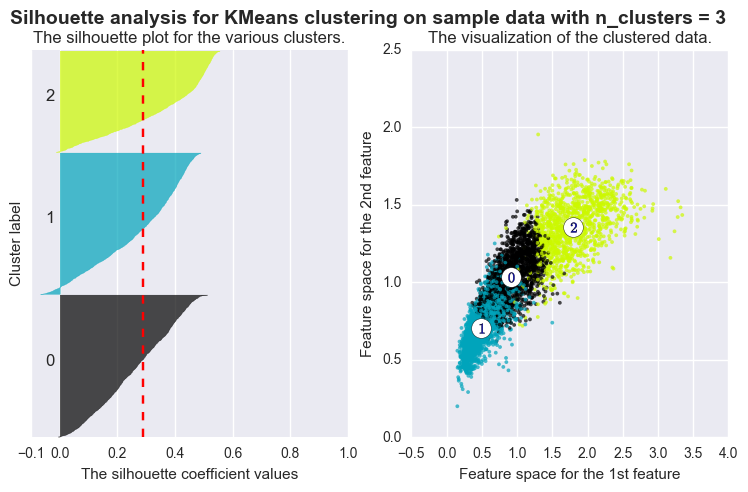

Cluster count: 4
('For k =', 4, 'The average silhouette_score is :', 0.30580446381752308)


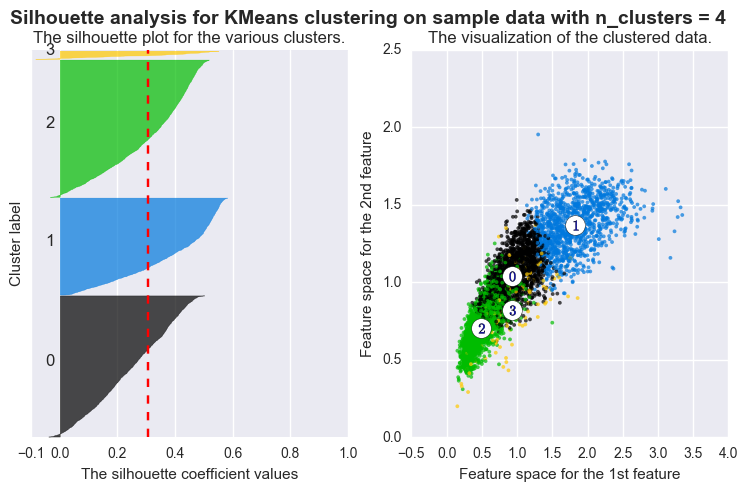

Cluster count: 5
('For k =', 5, 'The average silhouette_score is :', 0.25007770038254745)


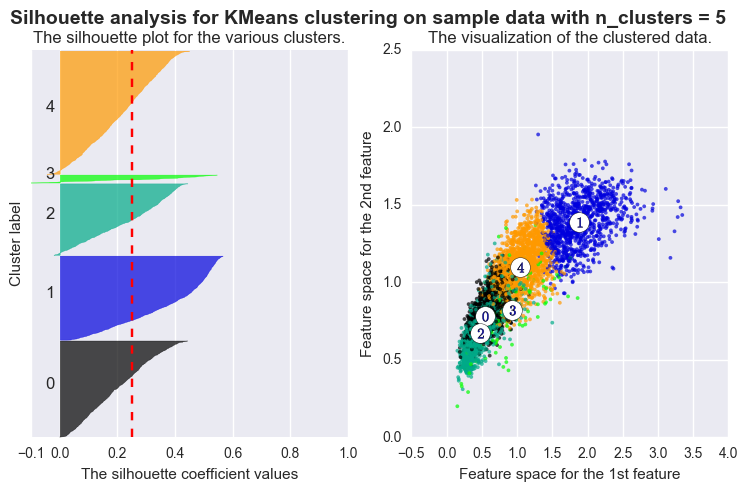

Cluster count: 6
('For k =', 6, 'The average silhouette_score is :', 0.25518185646284758)


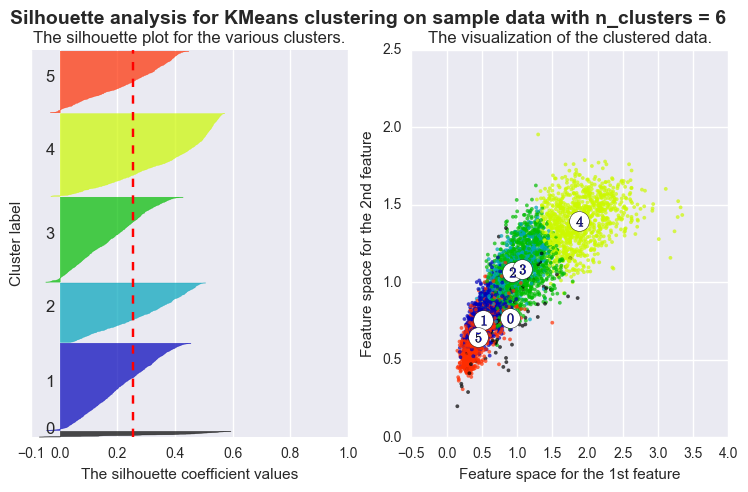

Cluster count: 7
('For k =', 7, 'The average silhouette_score is :', 0.23458746362339378)


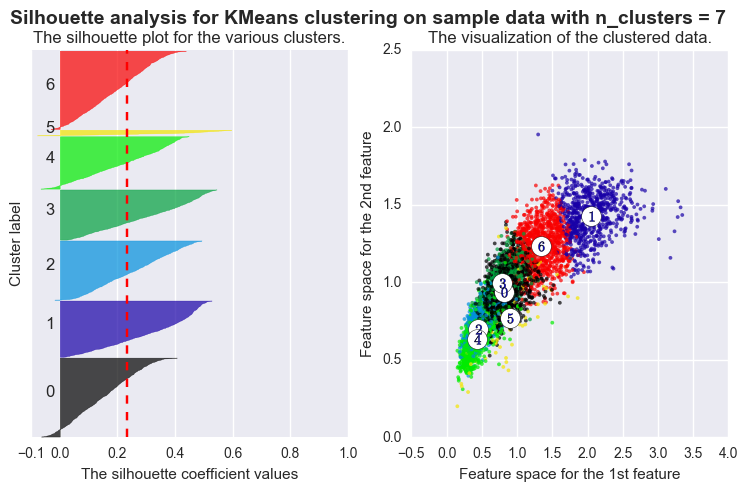

In [57]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

for k in range(3,8):
    # Debugging
    print("Cluster count: " + str(k))
    
    #############
    # Do the clustering using the main columns
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(dflq[main_cols])
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(dflq[main_cols], cluster_labels)
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)
    
    # Calculate the silhouette values
    sample_silhouette_values = silhouette_samples(dflq[main_cols], cluster_labels)
    
    #############
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, dflq.shape[0] + (k + 1) * 10])
    
    y_lower = 10
    
    # For each of the clusters...
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = cm.spectral(cluster_labels.astype(float) / k)
    ax2.scatter(dflq[main_cols[0]], dflq[main_cols[1]], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

    plt.show()

### Interpreting the Results

The results above suggest that 4 clusters is probably 'best' -- but note that that's only if we don't have any kind of underlying _theory_, other _empirical evidence_, or just a _reason_ for choosing a different value... Again, we're now getting in areas where _your judgement_ and your ability to _communicate your rationale_ to readers is the key thing. 

Let's repeat the 4-cluster process and then map it.

In [59]:
kmeans = KMeans(n_clusters=4).fit(dflq[main_cols])
dflq['KMMain'] = pd.Series(kmeans.labels_)

sdf = gdf.merge(dflq, left_on='lsoa11cd', right_on='GeoCode', how='inner')

sdf.sample(5)[['GeoCode','Group1LQ','Group4LQ','GroupNCLQ','KMMain']]

,GeoCode,Group1LQ,Group4LQ,GroupNCLQ,KMMain
817,E01000835,0.947,1.017,0.710,1
1708,E01001748,0.981,1.021,0.981,1
2420,E01002472,1.474,1.058,1.139,3
2900,E01002966,1.415,0.873,1.543,3
2949,E01003016,1.035,0.484,3.896,0


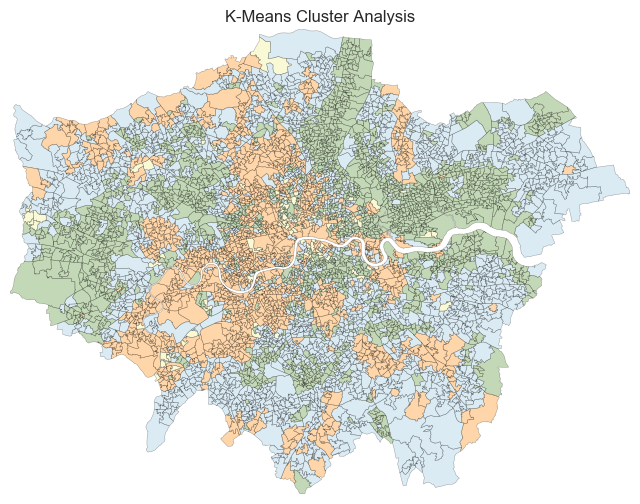

In [60]:
from pysal.contrib.viz import mapping as maps

# Where will our shapefile be stored
shp_link = os.path.join('data','lsoas.shp')

# Save it!
sdf.to_file(shp_link)

# And now re-load the values from the DBF file 
# associated with the shapefile.
values = np.array(ps.open(shp_link.replace('.shp','.dbf')).by_col('KMMain'))

types = ['unique_values']
for typ in types:
    maps.plot_choropleth(shp_link, values, typ, title='K-Means Cluster Analysis', figsize=(8,6))

To make sense of whether this is a 'good' result, you might want to visit [datashine](http://datashine.org.uk/#table=QS607EW&col=QS607EW0050&ramp=RdYlGn&layers=BTTT&zoom=10&lon=-0.1751&lat=51.4863) or think back to last year when we examined the NS-SeC data. 

You could also think of ways of plotting how these groups differ. For instance...

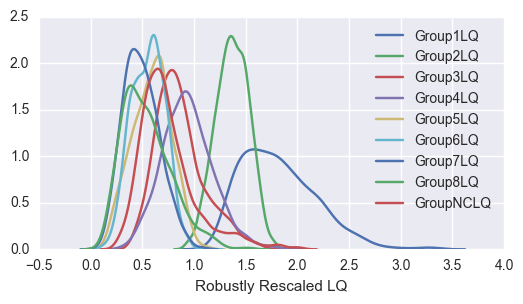

In [61]:
k1 = dflq[dflq.KMMain==3]
for c in main_cols:
    sns.distplot(k1[c], hist=False, kde=True, label=c, axlabel='LQ')

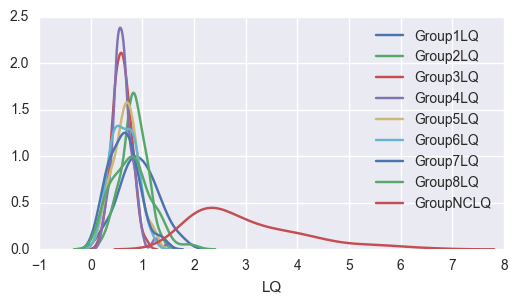

In [62]:
k1 = dflq[dflq.KMMain==0]
for c in main_cols:
    sns.distplot(k1[c], hist=False, kde=True, label=c, axlabel='LQ')

### _Really, really important _

Now would be a good time to think about _how_ standardisation and normalisation would have changed your results... and you might want to test whether applying these in a 'stronger' format (e.g. sklearn's `robust_rescale` and scipy's `boxcox`) help or hinder your analysis!

## DBScan

Of course, as we've said above _k_-means is just one way of clustering, DBScan is another. Unlike _k_-means, we don't need to specify the number of clusters in advance. Which sounds great, but we still need to specify _other_ parameters and these can have a huge impact on our results!

In [63]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN().fit(dflq[main_cols])

dflq['DBSCAN'] = pd.Series(dbs.labels_)

dflq.DBSCAN.value_counts()

 0    4744
-1      72
 1      14
 2       5
Name: DBSCAN, dtype: int64

In [64]:
sdf = gdf.merge(dflq, left_on='lsoa11cd', right_on='GeoCode', how='inner')

sdf.sample(5)[['GeoCode','Group1LQ','GroupNCLQ','KMMain','DBSCAN']]

,GeoCode,Group1LQ,GroupNCLQ,KMMain,DBSCAN
1279,E01001299,1.321,0.945,3,0
3027,E01003094,1.251,0.752,1,0
1804,E01001851,1.882,0.524,3,0
4782,E01033595,1.767,0.787,3,0
54,E01000058,0.254,0.925,2,0


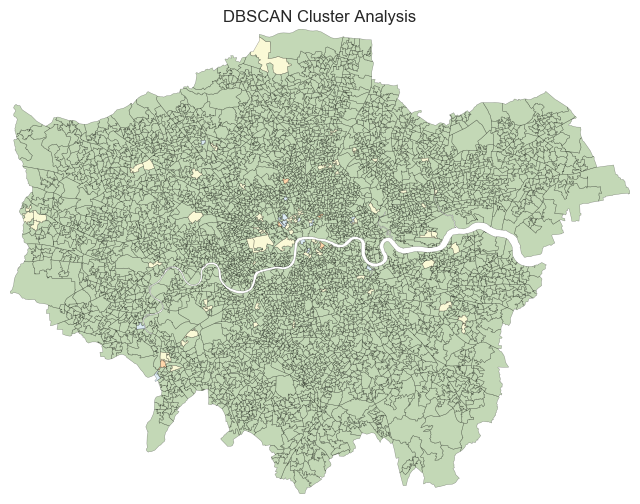

In [65]:
from pysal.contrib.viz import mapping as maps

# Where will our shapefile be stored
shp_link = os.path.join('data','lsoas.shp')

# Save it!
sdf.to_file(shp_link)

# And now re-load the values from the DBF file 
# associated with the shapefile.
values = np.array(ps.open(shp_link.replace('.shp','.dbf')).by_col('DBSCAN'))

types = ['unique_values']
for typ in types:
    maps.plot_choropleth(shp_link, values, typ, title='DBSCAN Cluster Analysis', figsize=(8,6))

So, rather less useful than we might have initially hoped... let's look at those parameters again.

In [68]:
help(DBSCAN)

Help on class DBSCAN in module sklearn.cluster.dbscan_:

class DBSCAN(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin)
 |  Perform DBSCAN clustering from vector array or distance matrix.
 |  
 |  DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
 |  Finds core samples of high density and expands clusters from them.
 |  Good for data which contains clusters of similar density.
 |  
 |  Read more in the :ref:`User Guide <dbscan>`.
 |  
 |  Parameters
 |  ----------
 |  eps : float, optional
 |      The maximum distance between two samples for them to be considered
 |      as in the same neighborhood.
 |  
 |  min_samples : int, optional
 |      The number of samples (or total weight) in a neighborhood for a point
 |      to be considered as a core point. This includes the point itself.
 |  
 |  metric : string, or callable
 |      The metric to use when calculating distance between instances in a
 |      feature array. If metric is a string or callable, it must 

In [82]:
dbs = DBSCAN().fit(dflq[main_cols])

dflq['DBSCAN'] = pd.Series(dbs.labels_)

dflq.DBSCAN.value_counts()

 0    4734
-1      80
 1      13
 2       8
Name: DBSCAN, dtype: int64

## Self-Organising Maps



In [113]:
import clusterpy

lsoas = clusterpy.importArcData(os.path.join('data','lsoas-subset'))

Loading data/lsoas-subset.dbf
Loading data/lsoas-subset.shp
Done


In [93]:
lsoas.cluster('som', ['Group1LQ','Group2LQ','Group3LQ','Group4LQ','Group5LQ','Group6LQ','Group7LQ','Group8LQ','GroupNCLQ'], 9, wType='queen', dissolve=1)

The parameters dissolve and dataOperations is not available for the this algorithm
Getting variables
Variables successfully extracted
Original Self Organizing Maps
---Generating SOM topology---
Creating grid
Done
Generating Uniform
Done [Uniform]
Getting variables
Variables successfully extracted
Done
FINAL SOLUTION:  [59, 2, 59, 3, 48, 5, 83, 17, 2, 35, 7, 0, 24, 37, 84, 86, 13, 86, 20, 83, 32, 57, 30, 65, 14, 42, 3, 27, 21, 36, 1, 2, 31, 13, 1, 1, 2, 13, 2, 1, 2, 42, 2, 1, 0, 1, 11, 31, 10, 59, 12, 1, 2, 76, 64, 31, 9, 9, 10, 3, 84, 14, 2, 4, 6, 1, 2, 2, 13, 75, 59, 59, 85, 48, 4, 23, 2, 12, 30, 12, 4, 16, 68, 59, 59, 77, 2, 24, 59, 12, 20, 3, 3, 25, 3, 11, 24, 29, 13, 3, 13, 31, 11, 14, 46, 33, 23, 86, 31, 3, 13, 5, 13, 12, 38, 14, 5, 53, 82, 82, 51, 62, 40, 67, 57, 65, 81, 54, 69, 57, 82, 83, 66, 67, 79, 82, 56, 66, 65, 65, 47, 56, 71, 68, 69, 69, 69, 69, 54, 66, 55, 87, 86, 87, 87, 78, 48, 38, 87, 89, 18, 39, 39, 28, 39, 87, 11, 44, 44, 85, 41, 2, 88, 49, 29, 88, 7, 13, 88, 9, 48,

In [112]:
lsoas.outputCluster

{'r2a': [],
 'r2aRoot': [],
 'som_20170121134016': {'OS': 'posix',
  'ObjectiveFuncionType': None,
  'SOMOutputLayer': <layer.Layer instance at 0x133bbad40>,
  'aggregationVariables': ('Group1LQ',),
  'algorithm': 'originalSOM',
  'distanceStat': None,
  'distanceType': None,
  'fieldName': 'som_20170121134016',
  'numberProccesor': None,
  'objectiveFunction': 0,
  'proccesorArchitecture': None,
  'proccesorIdentifier': None,
  'r2a': [88,
   0,
   88,
   10,
   75,
   12,
   42,
   26,
   10,
   6,
   39,
   1,
   83,
   74,
   62,
   45,
   80,
   64,
   3,
   23,
   41,
   56,
   30,
   82,
   49,
   41,
   20,
   83,
   29,
   7,
   1,
   0,
   31,
   22,
   10,
   11,
   0,
   23,
   0,
   20,
   0,
   50,
   11,
   0,
   1,
   11,
   30,
   25,
   20,
   87,
   41,
   2,
   0,
   75,
   71,
   32,
   0,
   10,
   20,
   11,
   60,
   34,
   2,
   21,
   42,
   0,
   0,
   10,
   69,
   54,
   87,
   88,
   54,
   58,
   20,
   14,
   0,
   23,
   13,
   21,
   3,
   26,
   77,
 

In [91]:
help(lsoas.save)

Help on method save in module clusterpy.core.layer:

save(self, filename) method of clusterpy.core.layer.Layer instance
    Save the Layer on a CP file
    
    :param filename: project name to create
    :type filename: string 
    
    **Examples** ::
    
        import clusterpy
        china = clusterpy.importArcData("clusterpy/data_examples/china")
        china.save('china')



In [111]:
#sdf['som'] = pd.Series()
#help(lsoas.results)
lsoas.outputCluster
#lsoas.outputCluster['som_20170121134016']['SOMOutputLayer']
#for r in lsoas.outputCluster['som_20170121134016']['r2a']:
#    print(r)
#pd.Series(lsoas.outputCluster['som_20170121134016']['r2a'], index=sdf.index)
#sdf.to_file(os.path.join('data','lsoas-subset-som'))

{'r2a': [],
 'r2aRoot': [],
 'som_20170121134016': {'OS': 'posix',
  'ObjectiveFuncionType': None,
  'SOMOutputLayer': <layer.Layer instance at 0x133bbad40>,
  'aggregationVariables': ('Group1LQ',),
  'algorithm': 'originalSOM',
  'distanceStat': None,
  'distanceType': None,
  'fieldName': 'som_20170121134016',
  'numberProccesor': None,
  'objectiveFunction': 0,
  'proccesorArchitecture': None,
  'proccesorIdentifier': None,
  'r2a': [88,
   0,
   88,
   10,
   75,
   12,
   42,
   26,
   10,
   6,
   39,
   1,
   83,
   74,
   62,
   45,
   80,
   64,
   3,
   23,
   41,
   56,
   30,
   82,
   49,
   41,
   20,
   83,
   29,
   7,
   1,
   0,
   31,
   22,
   10,
   11,
   0,
   23,
   0,
   20,
   0,
   50,
   11,
   0,
   1,
   11,
   30,
   25,
   20,
   87,
   41,
   2,
   0,
   75,
   71,
   32,
   0,
   10,
   20,
   11,
   60,
   34,
   2,
   21,
   42,
   0,
   0,
   10,
   69,
   54,
   87,
   88,
   54,
   58,
   20,
   14,
   0,
   23,
   13,
   21,
   3,
   26,
   77,
 

In [109]:
help(cpy.exportArcData)

AttributeError: 'module' object has no attribute 'exportArcData'